# Introduction
In this notebook we are reverse-engineering a one layer transformer trained to do five digit addition. We find that the model effectively represents and adds the digits 0 through 9 like scalars, but handles carries and modulo 10 operations unlike any off the shelf addition algorithm.

We are considering a variation of five digit addition where the numbers are written in a least digit first manner, so 17 is written 71 for example. In this variation of the task the "next token predictions" are aligned better with the logical order of operations. All numbers are also zero padded ($546+47843$ is written $64500+34874=983840$, for example) to obtain a consistent equation-format $a_1a_2a_3a_4a_5+b_1b_2b_3b_4b_5=r_1r_2r_3r_4r_5r_6$, and so the model can easily learn the base-10 posistional notation. 

Previous work (see for example [https://arxiv.org/abs/2310.13121], [https://arxiv.org/abs/2502.19981]) has shown that both small and large transformers often struggle with the long-range dependencies from the "cascading carries" in equations like 888 + 112 = 1000. I find that even a one-layer one attention-head transformers with no layernorm is able to realiably learn 5 digit _reverse_ addition by using the previous result-token ${r_{i-1}}$ to carry correctly. Somewhat surprisingly, I find that the learned digit embeddings are effectively 1d scalars in contrast to other work on learned number embeddings that tend to be periodic (see for example Nanda 2023, [https://arxiv.org/abs/2301.02679]) or even helical ([https://arxiv.org/abs/2502.00873]).  

# The Model

The model we will be analysing is a small one layer transformer with one attention-head and an embedding-dimension of 64 and no layernorm. Both token and posistional embeddings are learned, and so is the the unembedding which is not tied to the token-embeddings. 

### Loading

In [ ]:
import numpy as np
import torch, json, sys, math
import torch.nn.functional as F
from pathlib import Path
from utils import *
from interp_transformer import CausalTransformer 
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


RUN_NAME = "model"
MODELS_DIR = Path(f"{RUN_NAME}/")
device = "cpu"
tokenizer = AdditionTokenizer()
eq_tok = tokenizer.char_to_enc["="]
saved = json.load(open(MODELS_DIR / "run_dict.json"))
cfg = AdditionConfig(**saved["config"])
model = CausalTransformer(cfg).to(device)
state = torch.load(MODELS_DIR / "model.pt", map_location=device)
model.load_state_dict(state) 
model.eval()
print(model.parameters)


number of parameters: 0.05M
<bound method Module.parameters of CausalTransformer(
  (transformer): ModuleDict(
    (wte): Embedding(16, 64)
    (wpe): Embedding(32, 64)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): Identity()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=64, out_features=192, bias=False)
          (c_proj): Linear(in_features=64, out_features=64, bias=False)
        )
        (ln_2): Identity()
        (mlp): MLP(
          (c_fc): Linear(in_features=64, out_features=256, bias=False)
          (gelu): GELU(approximate='none')
          (relu): ReLU()
          (c_proj): Linear(in_features=256, out_features=64, bias=False)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): Identity()
  )
  (lm_head): Linear(in_features=64, out_features=16, bias=False)
)>


### Extracting/defining matricies

In [2]:
with torch.no_grad():

    # embedding
    WTE = model.transformer.wte.weight
    WPE = model.transformer.wpe.weight
    W_u = model.lm_head.weight
    W_mlp_fc = model.transformer.h[0].mlp.c_fc.weight
    W_mlp_out = model.transformer.h[0].mlp.c_proj.weight

    # inside your with torch.no_grad():
    block = model.transformer.h[0]

    # extracting the value weight
    attn = model.transformer.h[0].attn
    d = attn.n_embd
    H = attn.n_head
    d_head = d // H
    Wv = attn.c_attn.weight [2*d:, :]
    Wo = block.attn.c_proj.weight 

### Inference
Now we do infernce over many equations to get a dataset of activations which we will hook and use for analysis later.

In [3]:
cache = {}

def hook_x_in(module, inputs):
    cache["x_in"] = inputs[0].detach()         # (B,T,D)
    return None

def hook_attn(module, inputs, output):
    y, probs = output
    cache["attn_y"] = y.detach()         # (B,T,D)
    cache["probs"]  = probs.detach()     # (B,1,T,T)
    return output

def hook_mlp(module, inputs, output):
    cache["mlp_out"] = output.detach()     # (B,1,T,T)
    return output

h1 = block.register_forward_pre_hook(hook_x_in)
h2 = block.attn.register_forward_hook(hook_attn)
h3 = block.mlp.register_forward_hook(hook_mlp)

with torch.no_grad():
    N = 10000
    rows = []   
    alphas = []
    for _ in range(N):
        a = torch.randint(saved["low_num"], saved["high_num"], (1,)).item()
        b = torch.randint(saved["low_num"], saved["high_num"], (1,)).item()
        eq = format_equation(
            int1=a, int2=b, result=a+b,
            zero_pad_digits=saved["zero_pad_digits"],
            summand_digits=saved["summand_digits"],
            reverse_digits=saved["reverse_digits"],
            thinking_tokens=saved["thinking_tokens"]
        )
        ids = torch.tensor([tokenizer.encode(eq, padding=False, max_len=saved["max_len"])])
        out = model(ids, return_hidden=True) 
        y = cache["attn_y"][0]                 # (T,D)
        alpha = cache["probs"][0,0]            # (T,T)
        x_in = cache["x_in"]
        mlp_out = cache["mlp_out"]

        # reconstruct WTE / WPE contributions *under value+output linear maps*
        T = ids.size(1)
        pos = torch.arange(T, device=ids.device)
        x_wte = model.transformer.wte(ids[0])        # (T,D)
        x_wpe = model.transformer.wpe(pos)           # (T,D)

        # attention mixing to target t:
        # y_wte_hat[t] = sum_s alpha[t,s] * v_wte[s], same for wpe
        attn_wte_vec = alpha @ (x_wte @ Wv.T) @ Wo.T                      # (T,D)
        attn_wpe_vec = alpha @ (x_wpe @ Wv.T) @ Wo.T                      # (T,D)

        # The relevant indices are 13:17, so we loop through those. 
        for t in range(13, 17): 
            ai = int(ids[0, t-11])
            bi = int(ids[0, t-5])
            aim1 = int(ids[0, t-12])
            bim1 = int(ids[0, t-6])
            p_ai   = float(alpha[t, t-11])
            p_bi   = float(alpha[t, t-5])
            p_aim1 = float(alpha[t, t-12])
            p_bim1 = float(alpha[t, t-6])

            rows.append({
                "eq":eq,
                "ids": ids[0], 
                "x_in": x_in[0, t],
                "x_wte": x_wte[t],
                "x_wpe": x_wpe[t],
                "attn_probs":alpha, 
                "attn_out":y[t, :],
                "attn_wte_vec":attn_wte_vec[t],
                "attn_wpe_vec":attn_wpe_vec[t],
                "mlp_out": mlp_out[0, t],
                "ai": ai, "bi": bi, "ai-1": aim1, "bi-1": bim1,
                "p_ai": p_ai, "p_bi": p_bi, "p_ai-1": p_aim1, "p_bi-1": p_bim1,
                "ri":int(ids[0,t+1]), "ri-1":int(ids[0,t]), 
                "sx":(5/11)*(ai+bi) + (1/22)*(aim1 + bim1)
            })
h1.remove()
h2.remove()
h3.remove()

# Digit embeddings

### Token embeddings

First we can investigate the token embeddings, which are a obtained with the linear map $f:\{0,...,10\} \mapsto \mathbb{R}^{64}$ using the token embedding-matrix $W_{tok}$. By after doing PCA we see that about $90\%$ of the variance is explained by the first principal component. What is more, the PC1-projected the digit embeddings are ordered numerically and equally spaced. So, if we regress the digit valued onto the projected PC1-values, we get the linear fit $ a \approx 0.17$, $b=-0.764$ with $R^2=0.9997$. The upshot is that the learned digit-embeddings are very close to digit scalars along the first principal component. 


PCA explained variance: tensor([0.9012, 0.0439, 0.0202, 0.0122, 0.0066])

----Linear fit on pc1----
Differences along pc1 (pc1[i+1] - pc1[i]):
 tensor([0.1632, 0.1684, 0.1757, 0.1818, 0.1769, 0.1600, 0.1661, 0.1667, 0.1530])

PC1 linear fit: a=0.169757, b=-0.763905, R^2=0.9997


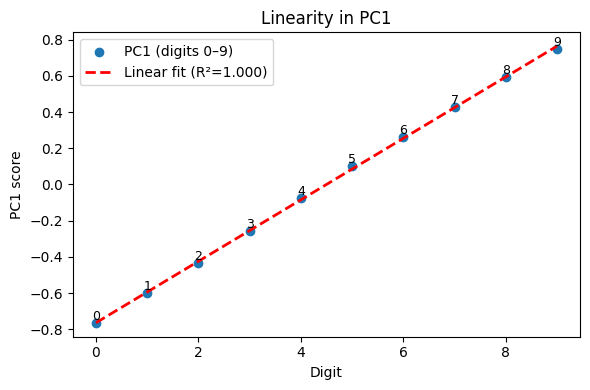

R^2 for E_d ≈ mu + d*v = 0.9009252786636353


In [4]:
with torch.no_grad():

    # token embeddings
    digit_ids = torch.tensor([tokenizer.char_to_enc[str(d)] for d in range(10)])
    digit_emb = WTE[digit_ids] # (10, d)
    digit_mu = digit_emb.mean(dim=0, keepdim=True)
    digit_emb_c = digit_emb - digit_mu

    # pca
    U, S, Vh = torch.linalg.svd(digit_emb_c, full_matrices=False)
    pc1 = U[:,0] * S[0]
    pc2 = U[:,1] * S[1]
    v1_emb = Vh[0] 
    var_explained = (S**2) / (S**2).sum()
    print("\nPCA explained variance:", var_explained[:5])
    
    # linear fit on PC1
    print("\n----Linear fit on pc1----")
    X = torch.stack([torch.ones_like(digit_ids), digit_ids.to(dtype=pc1.dtype)], dim=1)
    theta = torch.linalg.lstsq(X, pc1).solution 
    b, a = theta[0].item(), theta[1].item()
    y_hat = (X @ theta)
    r2 = 1.0 - (torch.sum((pc1 - y_hat)**2) / torch.sum((pc1 - pc1.mean())**2) + 1e-12)
    print("Differences along pc1 (pc1[i+1] - pc1[i]):\n", (pc1[1:] - pc1[:-1]))
    print(f"\nPC1 linear fit: a={a:.6f}, b={b:.6f}, R^2={float(r2):.4f}")
    plt.figure(figsize=(6,4))
    plt.scatter(digit_ids, pc1, label="PC1 (digits 0–9)")
    plt.plot(digit_ids, y_hat.detach(), lw=2, label=f"Linear fit (R²={float(r2):.3f})", color="red", ls="--")
    for i in range(10):
        plt.text(digit_ids[i], pc1[i], str(i), ha="center", va="bottom", fontsize=9)
    plt.xlabel("Digit")
    plt.ylabel("PC1 score")
    plt.title("Linearity in PC1")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Least-squares: E ≈ A @ theta, where theta stacks [mu, v] in R^{2 x d}
    A = torch.cat([torch.ones_like(digit_ids.unsqueeze(1)), digit_ids.unsqueeze(1).float()], dim=1)  # [10, 2]
    beta, *_ = torch.linalg.lstsq(A, digit_emb)       # theta: [2, d]
    digit_emb_hat = A @ beta                    # [10, d]
    resid = (digit_emb - digit_emb_hat)
    r2 = 1 - (resid.pow(2).sum() / digit_emb_c.pow(2).sum())
    print("R^2 for E_d ≈ mu + d*v =", float(r2))

### Posistional embeddings

For the posistional embeddings we find that $a_i$ and $b_i$ are embedded very similarly, which reflects the commutativity of the attition-task. 

In [5]:
pos_emb = WPE[torch.arange(20)]
aibi_norms = []
for i in range(1, 6):
    aibi_norms.append(torch.norm(pos_emb[i] - pos_emb[i+6]))
    print(f"||a_{i}-b_{i}||=", round(torch.norm(pos_emb[i] - pos_emb[i+6]).item(),4))

norms = []
for i in range(20): 
    for j in range(i+1, 20): 
        norms.append(torch.norm(pos_emb[i] - pos_emb[j]).item())
print(f"\n mean posistional distance =", round(sum(norms)/len(norms),4))

||a_1-b_1||= 0.1555
||a_2-b_2||= 0.168
||a_3-b_3||= 0.163
||a_4-b_4||= 0.1771
||a_5-b_5||= 0.1802

 mean posistional distance = 1.6854


# Attention
Tldr: The attention output is effectively a scaled version of $a_i + b_i + 0.1(a_{i-1} + b_{i-1})$. 

### PCA on the attention output
When we do PCA on the attention output, we see that the the first principal component explains more than $99\%$ of the variance, which means than all attention outputs effectively lie on a line. 

In [6]:
# pca on the wte-part of the attention output.
attn_wte_E = torch.tensor([r["attn_wte_vec"].tolist() for r in rows])
Ec = attn_wte_E - attn_wte_E.mean(dim=0, keepdim=True)
U, S, Vh = torch.linalg.svd(Ec, full_matrices=False)
e_tilde_unit = Vh[0]
pc1 = U[:,0] * S[0]
var_explained = (S**2) / (S**2).sum()
print("\nPCA explained variance:", torch.round(var_explained[:5], decimals=3))


PCA explained variance: tensor([0.9990, 0.0010, 0.0000, 0.0000, 0.0000])


### The attention pattern
After staring at a few attention-patterns, you will note that they do not change much depending on the digit values. For the first and smallest result digit $r_1$, the model attends only to $a_1$ and $b_1$. This makes sense as these are the only two digits relevant for calculating $r_1$. However, in the remaining result-digits (execpt for $r_6$), we see a pretty consistent staircase pattern, where the model attends mostly to $a_i$ and $b_i$ but also a little to $a_{i-1}$ and $b_{i-1}$. 

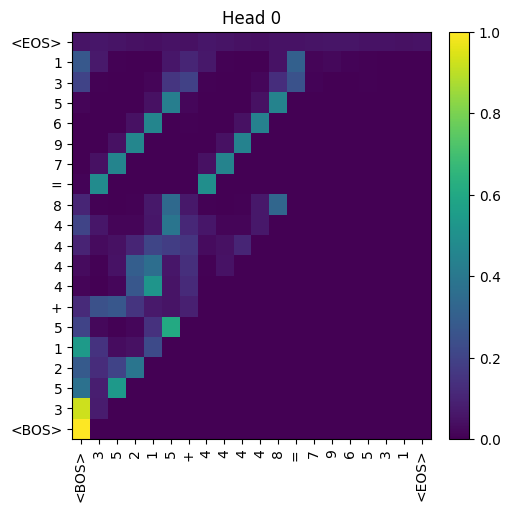

In [7]:
PLOT_EQ = 0
att = rows[PLOT_EQ]["attn_probs"] 
ids = rows[PLOT_EQ]["ids"] 
chars = [tokenizer.enc_to_char[e.item()] for e in ids]
def plot_single_head(att, chars, head=0):
    fig, ax = plt.subplots(1, 1, figsize=(max(2.5, 0.25*T), max(2, 0.25*T)), constrained_layout=True)
    im = ax.imshow(att, origin="lower", aspect="auto")
    ax.set_title(f"Head {head}")
    ax.set_xticks(range(T)); ax.set_xticklabels(chars, rotation=90)
    ax.set_yticks(range(T)); ax.set_yticklabels(chars)
    fig.colorbar(im, ax=ax)
    plt.show()
plot_single_head(att, chars)

To verify the stair-case pattern, we can average the attention-probabilities over many different digit values. We observere a very clear pattern, namely that $p_{a_i} \approx p_{b_i} \approx 0.45$ and $p_{a_{i-1}} \approx p_{b_{i-1}} \approx 0.046$ for $i \in \{2,3,4,5\}$ independently of the digit values. Crucially, we see that $(p_{a_i} + p_{b_i}) \approx 10 \cdot (p_{a_{i-1}} + p_{b_{i-1}})$ – corresponding to an increase of digit placement. 

In [8]:
P = torch.stack([row["attn_probs"] for row in rows])[:, 13:17, :]
P_mean = P.mean(dim=0)
P_std = P.std(dim=0)
print("Predicting r_i, we get the attention-probabilities:")
for i in range(4): 
    p_ai = P_mean[i, 2+i]
    p_aim1 = P_mean[i, 1+i]
    p_bi = P_mean[i, 8+i]
    p_bim1 = P_mean[i, 1+i]
    std_ai = P_std[i, 2+i]
    std_aim1 = P_std[i, 1+i]
    std_bi = P_std[i, 8+i]
    std_bim1 = P_std[i, 1+i]
    print(f"i={i+2}:")
    print(f"    p_ai.  = {p_ai:.5f} ± {2*std_ai:.5f} (95% CI)")
    print(f"    p_bi   = {p_bi:.5f} ± {2*std_bi:.5f} (95% CI)")
    print(f"    p_ai-1 = {p_aim1:.5f} ± {2*std_aim1:.5f} (95% CI)")
    print(f"    p_bi-1 = {p_bim1:.5f} ± {2*std_bim1:.5f} (95% CI)")
    print(f"    sum    = {p_ai+p_bi+p_aim1+p_bim1:.5f}")

Predicting r_i, we get the attention-probabilities:
i=2:
    p_ai.  = 0.45006 ± 0.02613 (95% CI)
    p_bi   = 0.44946 ± 0.02607 (95% CI)
    p_ai-1 = 0.04639 ± 0.00458 (95% CI)
    p_bi-1 = 0.04639 ± 0.00458 (95% CI)
    sum    = 0.99229
i=3:
    p_ai.  = 0.45104 ± 0.02604 (95% CI)
    p_bi   = 0.45182 ± 0.02606 (95% CI)
    p_ai-1 = 0.04630 ± 0.00437 (95% CI)
    p_bi-1 = 0.04630 ± 0.00437 (95% CI)
    sum    = 0.99546
i=4:
    p_ai.  = 0.44837 ± 0.02629 (95% CI)
    p_bi   = 0.44835 ± 0.02623 (95% CI)
    p_ai-1 = 0.04662 ± 0.00457 (95% CI)
    p_bi-1 = 0.04662 ± 0.00457 (95% CI)
    sum    = 0.98997
i=5:
    p_ai.  = 0.43469 ± 0.02498 (95% CI)
    p_bi   = 0.43573 ± 0.02499 (95% CI)
    p_ai-1 = 0.04495 ± 0.00429 (95% CI)
    p_bi-1 = 0.04495 ± 0.00429 (95% CI)
    sum    = 0.96032


### The value-transformation
Since the token-embeddings where mostly linear, we should expect the value-transformation of the token-embeddings to also be mostly linear. Somewhat notably, the value-matrix alings the digits even better in one dimension PC1, which now explains $97\%$ of the variance in the token-embeddings. So, for a digit with value $d$ has the approximate value-embedding $e_{tok}V \approx \mu + d \cdot v$ where $v$ is PC1.


PCA explained variance: tensor([9.9713e-01, 2.4059e-03, 3.9307e-04, 5.2940e-05, 8.6139e-06])

----Linear fit on pc1----
Differences along pc1 (pc1[i+1] - pc1[i]): tensor([0.5595, 0.8077, 0.8871, 0.9297, 0.8998, 0.8692, 0.8372, 0.8095, 0.7758])
PC1 linear fit: a=0.847096, b=-3.811934, R^2=0.9986


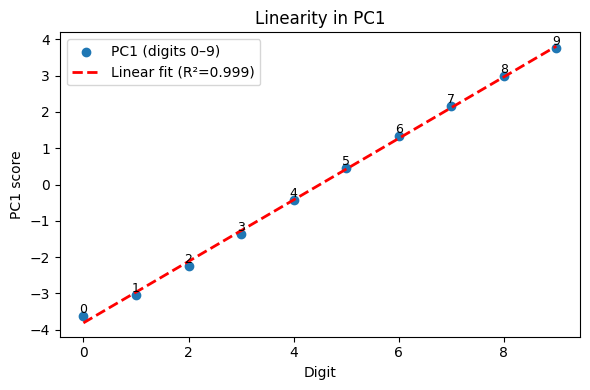

In [9]:
with torch.no_grad():
    
    attn = model.transformer.h[0].attn
    d = attn.n_embd
    H = attn.n_head
    d_head = d // H
    value = attn.c_attn.weight[2*d:, :] # (3d, d)

    # embedding
    VE = WTE[digit_ids] @ value.T  # (10, d)

    # pca
    U, S, Vh = torch.linalg.svd(VE - VE.mean(dim=0, keepdim=True), full_matrices=False)
    pc1 = U[:,0] * S[0]
    pc2 = U[:,1] * S[1]
    var_explained = (S**2) / (S**2).sum()
    print("\nPCA explained variance:", var_explained[:5])
    
    # Linear fit on PC1
    print("\n----Linear fit on pc1----")
    X = torch.stack([torch.ones_like(digit_ids), digit_ids.to(dtype=pc1.dtype)], dim=1)
    theta = torch.linalg.lstsq(X, pc1).solution 
    b, a = theta[0].item(), theta[1].item()
    y_hat = (X @ theta)
    r2 = 1.0 - (torch.sum((pc1 - y_hat)**2) / torch.sum((pc1 - pc1.mean())**2) + 1e-12)
    print("Differences along pc1 (pc1[i+1] - pc1[i]):", (pc1[1:] - pc1[:-1]))
    print(f"PC1 linear fit: a={a:.6f}, b={b:.6f}, R^2={float(r2):.4f}")
    plt.figure(figsize=(6,4))
    plt.scatter(digit_ids, pc1, label="PC1 (digits 0–9)")
    plt.plot(digit_ids, y_hat.detach(), lw=2, label=f"Linear fit (R²={float(r2):.3f})", color="red", ls="--")
    for i in range(10):
        plt.text(digit_ids[i], pc1[i], str(i), ha="center", va="bottom", fontsize=9)
    plt.xlabel("Digit")
    plt.ylabel("PC1 score")
    plt.title("Linearity in PC1")
    plt.legend()
    plt.tight_layout()
    plt.show()
        

### What is being calculated? 

Using the approximations from the two previous sections, we expect the attention output to be approximately 
$$y_i = \sum_{j=1}^{i} \text{Softmax}(q_i^Tk_j) v_j  \approx \mu v + [(5/11)(a_i + b_i)v + (1/22)(a_{i-1} + b_{i-1})]v$$
when predictiong $r_i$. Let us see if we can verify this empirically. We fit three regressions with attention-output projected onto the first principal component as the target. 

1. The hard-coded model $y_i = \beta_0 + \beta_1 \cdot \text{sa}_\text{hardcoded}$, where $\text{sa}_\text{hardcoded} := [(5/11)(a_i + b_i)v + (1/22)(a_{i-1} + b_{i-1})]$.
2. The empirical attention-weight model $y_i = \beta_0 + \beta_1 \cdot \text{sa}_i$, where $\text{sa}_i : =(\alpha_{a_i}a_i+\alpha_{b_i}b_i+\alpha_{a_{i-1}}a_{i-1}+\alpha_{b_{i-1}}a_{i-1})$. 
3. The full regression. $y_i = \beta_0 + \beta_1 a_i + \beta_2 b_i + \beta_3 a_{i-1} + \beta_4b_{i-1}$.

All models get $R^2>0.99$ with a fit very close to

$$
y_i \approx 27 - 2.49(a_i + b_i) - 0.249(a_{i-1} + b_{i-1}).
$$

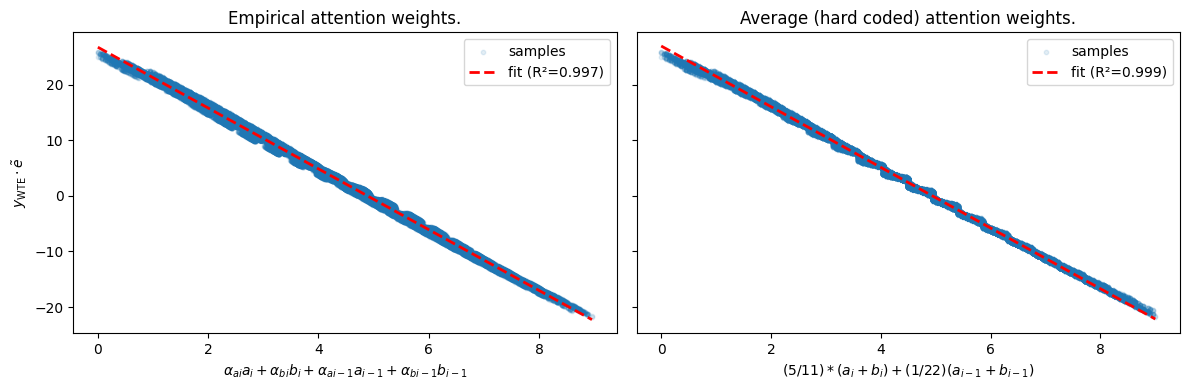



Fitting y_wte_proj ≈ β0 + β1 * s_a
 empirical: y = 26.7996 + -5.4777·sa,  R^2=0.9974
 hardcoded: y = 27.0157 + -5.4645·sa_hardcoded, R^2=0.9986


Fitting y_wte_proj ≈ β0 + β_ai*ai + β_bi*bi + β_a_{i-1}*a_{i-1} + β_b_{i-1}*b_{i-1}
  R^2=0.9986, coeffs q: bias=27.0926, ai=-2.4821, bi=-2.4838, ai-1=-0.2580, bi-1=-0.2577
  Hard-coded coefficients: bias=27.0157 ai=bi=-2.4839 ai-1=bi-1=-0.2484



In [10]:
# ----- 1) Scalar-on-axis regression & plot -----
y1_wte = [] # scalar: (y_wte_vec · e_tilde)
sa   = []   # scalar: α_ai*a_i + α_bi*b_i + α_ai-1*a_{i-1} + α_bi-1*b_{i-1}
sa_hardcoded = []

# project vectors onto the attention-write digit axis e_tilde
for r in rows:
    y1_wte.append(float(r["attn_wte_vec"] @ e_tilde_unit))
    sa.append(r["p_ai"]*r["ai"] + r["p_bi"]*r["bi"] + r["p_ai-1"]*r["ai-1"] + r["p_bi-1"]*r["bi-1"])
    sa_hardcoded.append((r["ai"] + r["bi"])*(10/22) + (r["ai-1"] + r["bi-1"])/22)
y1_wte = torch.tensor(y1_wte, dtype=torch.float32)
sa   = torch.tensor(sa,   dtype=torch.float32)
sa_hardcoded  = torch.tensor(sa_hardcoded,   dtype=torch.float32)

# fit y1_wte ≈ β0 + β1 * sa
# --- fit #1: learned alphas ---
X1 = torch.stack([torch.ones_like(sa), sa], dim=1)
beta1 = torch.linalg.lstsq(X1, y1_wte).solution
yhat1 = X1 @ beta1
r2_1  = 1 - ((y1_wte - yhat1).pow(2).sum() / ((y1_wte - y1_wte.mean())**2).sum() + 1e-12)

# --- fit #2: hard-coded pattern (10/22,10/22,1/22,1/22) scaled as you set in s_a2 ---
X2 = torch.stack([torch.ones_like(sa_hardcoded), sa_hardcoded], dim=1)
beta2 = torch.linalg.lstsq(X2, y1_wte).solution
yhat2 = X2 @ beta2
r2_2  = 1 - ((y1_wte - yhat2).pow(2).sum() / ((y1_wte - y1_wte.mean())**2).sum() + 1e-12)

# --- plots side-by-side ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
# Left: empirical α
ax1.scatter(sa, y1_wte, s=10, alpha=0.12, label="samples")
xs1 = torch.linspace(sa.min(), sa.max(), 200)
ys1 = beta1[0] + beta1[1]*xs1
ax1.plot(xs1, ys1, lw=2, label=f"fit (R²={float(r2_1):.3f})", color="red", ls="--")
ax1.set_xlabel(r"$\alpha_{ai}a_i+\alpha_{bi}b_i+\alpha_{ai-1}a_{i-1}+\alpha_{bi-1}b_{i-1}$")
ax1.set_ylabel(r"$y_{\mathrm{WTE}}\cdot \tilde e$")
ax1.set_title("Empirical attention weights.")
ax1.legend()
# Right: hard-coded α
ax2.scatter(sa_hardcoded, y1_wte, s=10, alpha=0.12, label="samples")
xs2 = torch.linspace(sa_hardcoded.min(), sa_hardcoded.max(), 200)
ys2 = beta2[0] + beta2[1]*xs2
ax2.plot(xs2, ys2, lw=2, label=f"fit (R²={float(r2_2):.3f})", color="red", ls="--")
ax2.set_xlabel(r"$(5/11)*(a_i+b_i)+(1/22)(a_{i-1}+b_{i-1})$")
ax2.set_title("Average (hard coded) attention weights.")
ax2.legend()
plt.tight_layout()
plt.show()

print("\n\nFitting y_wte_proj ≈ β0 + β1 * s_a")
print(f" empirical: y = {beta1[0].item():.4f} + {beta1[1].item():.4f}·sa,  R^2={float(r2_1):.4f}")
print(f" hardcoded: y = {beta2[0].item():.4f} + {beta2[1].item():.4f}·sa_hardcoded, R^2={float(r2_2):.4f}")

# ----- 2) Coefficient recovery: per-role regression & bar plot -----
# y1_wte ≈ β0 + β_ai*ai + β_bi*bi + β_aim1*a_{i-1} + β_bim1*b_{i-1}
M = []
tgt = []
for r in rows:
    M.append([1.0, r["ai"], r["bi"], r["ai-1"], r["bi-1"]])
    tgt.append(float(r["attn_wte_vec"] @ e_tilde_unit))
M = torch.tensor(M, dtype=torch.float32)
tgt = torch.tensor(tgt, dtype=torch.float32)
beta_full = torch.linalg.lstsq(M, tgt).solution
yhat_full = M @ beta_full
r2_full = 1 - ((tgt - yhat_full).pow(2).sum() / ((tgt - tgt.mean())**2).sum() + 1e-12)
print("\n\nFitting y_wte_proj ≈ β0 + β_ai*ai + β_bi*bi + β_a_{i-1}*a_{i-1} + β_b_{i-1}*b_{i-1}")
print(f"  R^2={float(r2_full):.4f}, coeffs q:",
      f"bias={beta_full[0].item():.4f}, ai={beta_full[1].item():.4f}, bi={beta_full[2].item():.4f},",
      f"ai-1={beta_full[3].item():.4f}, bi-1={beta_full[4].item():.4f}")
print(f"  Hard-coded coefficients:", f"bias={beta2[0].item():.4f}", 
      f"ai=bi={beta2[1].item() * (10/22):.4f}",f"ai-1=bi-1={beta2[1].item() * (1/22):.4f}\n")

### What about the posistional embeddings?

If you look closely at the analysis above, we have only considered the attention-output of the token embeddings.
$$y_i = \sum_{j=1}^{i}\text{Softmax}(q_i^Tk_j)(x_{pos} + x_{tok})V = \underbrace{\sum_{j=1}^{i}\text{Softmax}(q_i^Tk_j)x_{tok}V}_{A} + \underbrace{\sum_{j=1}^{i}\text{Softmax}(q_i^Tk_j)x_{pos}V}_{B}$$
We have only considered A. But it turns out that the posistional embeddings are pretty much only used for the attention-weights so the $A+B$ output is almost identical to the $A$ output alone plus an intercept. 

In [11]:
# WPE-only projection on the digit axis (same rows loop as you already have)
y1_wpe = torch.tensor([float(r["attn_wpe_vec"] @ e_tilde_unit) for r in rows])
print("\nSo what about the posistional embeddings?")
print("[WPE axis stats]")
print("  mean(y_WPE·ẽ):", float(y1_wpe.mean()), "  std:", float(y1_wpe.std()))

# Does WPE axis correlate with digit sum?
X = torch.stack([torch.ones_like(sa), sa], dim=1)
beta_wpe = torch.linalg.lstsq(X, y1_wpe).solution
yhat_wpe = X @ beta_wpe
r2_wpe = 1 - ((y1_wpe - yhat_wpe).pow(2).sum() / ((y1_wpe - y1_wpe.mean())**2).sum() + 1e-12)
print(f"  Regress WPE on s_a: y≈{beta_wpe[0].item():.4f}+{beta_wpe[1].item():.4f}s,  R^2={float(r2_wpe):.4f}")
print("Since R^2 is small, then we conclude that the the posistional encodings are absorbed by the intercept.\n")


So what about the posistional embeddings?
[WPE axis stats]
  mean(y_WPE·ẽ): -3.024091958999634   std: 0.5019963979721069
  Regress WPE on s_a: y≈-3.0533+0.0066s,  R^2=0.0006
Since R^2 is small, then we conclude that the the posistional encodings are absorbed by the intercept.



# The MLP Layer

After the attention-layer, we have a scaled version of $s_i = a_i + b_i + 0.1(a_{i-1} + b_{i-1})$, which for most $a$ and $b$ values can be fed to a mod 10 operation to yield a correct $r_i$ prediction. However, if for example $a_{i-1} + b_{i-1} = 9$ and $r_{i-1}=0$, then a one must have been carried in the previous step, and then the "$r_i = s_i \text{ mod } 10$ heuristic" is incorrect! So, besides some modulo calculation, we should also expect to see some use of $r_{i-1}$ in the mlp layer. 

### The first linear layer of the mlp 

PCA reveals that despite the attention output and x embeddings not being aligned, they are both projected down onto a linear 1D subspace by the first linear layer of the mlp. Therefore, we can once again do linear regression on the first principal component direction. We get an amazing fit and see how the remainder-term $r_{i-1}$ is used. 

In [12]:
pre_relu  = torch.stack([((r["x_in"] + r["attn_out"]) @ W_mlp_fc.T) for r in rows])
mu = pre_relu.mean(0, keepdim=True).detach()
_, S, Vh_pre = torch.linalg.svd(pre_relu - mu, full_matrices=False)
v = (Vh_pre[0] / Vh_pre[0].norm()).detach()
var_explained = (S**2) / (S**2).sum()
print("PCA explained variance:", torch.round(var_explained[:5], decimals=3))

# 1) Compute the scalar target z_i along the shared axis e
s = torch.tensor([(((r["x_in"] + r["attn_out"]) @ W_mlp_fc.T) @ v).item() for r in rows]).detach().cpu().numpy()
# s = torch.tensor([(((r["x_in"] + r["attn_out"]) @ W_mlp_fc.T - mu) @ v).item() for r in rows]).detach().cpu().numpy()

# 2) Extract numeric features
a_i   = np.array([r["ai"]   for r in rows], dtype=float)
b_i   = np.array([r["bi"]   for r in rows], dtype=float)
a_im1 = np.array([r["ai-1"] for r in rows], dtype=float)
b_im1 = np.array([r["bi-1"] for r in rows], dtype=float)
r_im1 = np.array([r["ri-1"] for r in rows], dtype=float)

# 3) Design matrix with bias
X = np.column_stack([np.ones_like(a_i), a_i, b_i, a_im1, b_im1, r_im1])

# 4) Linear regression
beta, *_ = np.linalg.lstsq(X, s, rcond=None)
names = ["bias","a_i","b_i","a_{i-1}","b_{i-1}","r_{i-1}"]
for n, w in zip(names, beta):
    print(f"{n:>8s}: {w:8.4f}")
s_hat = X @ beta
r2 = 1 - np.sum((s - s_hat)**2)/np.sum((s - s.mean())**2)
print(f"R² = {r2:.3f}")

PCA explained variance: tensor([0.9990, 0.0010, 0.0000, 0.0000, 0.0000], grad_fn=<RoundBackward1>)
    bias: -230.3512
     a_i:  23.7645
     b_i:  23.7741
 a_{i-1}:   2.4631
 b_{i-1}:   2.4664
 r_{i-1}:  -2.1008
R² = 0.999


### Analyzing the ReLU
The relu-activation is harder to analyse, but the saving grace is that it preserves the 1D intrinsic dimensionality despite being a coordinate-wise function. This means that the output will now be some 1D curve instead of a line. After applying PCA we see that the explained variance now mostly spread out on the first two principal components, and the curve looks a little like a parabola. 

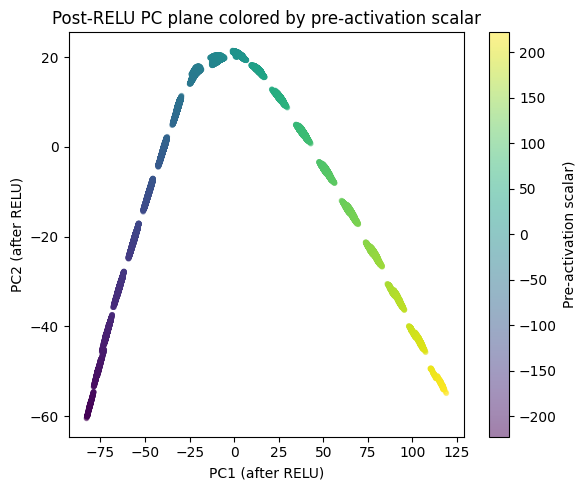

In [13]:
# Center for PCA/SVD
post_relu = torch.stack([F.relu((r["x_in"] + r["attn_out"]) @ W_mlp_fc.T) for r in rows])
post_relu_c = post_relu - post_relu.mean(dim=0, keepdim=True)
_, S, Vh = torch.linalg.svd(post_relu_c, full_matrices=False) 

# Pre-activation scalar (color)
s_pre = (pre_relu @ v).detach().cpu().numpy()

# --- Get post-RELU PCs and project to 2D ---
pc1_post, pc2_post = Vh[0].detach(), Vh[1].detach()
proj_2d = (post_relu_c @ torch.stack([pc1_post, pc2_post], dim=1)).detach().cpu().numpy()

# --- Scatter colored by pre-activation scalar ---
import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))
sc = plt.scatter(proj_2d[:,0], proj_2d[:,1],
                 c=s_pre, cmap="viridis", s=10, alpha=0.5)
plt.colorbar(sc, label="Pre-activation scalar)")
plt.xlabel("PC1 (after RELU)")
plt.ylabel("PC2 (after RELU)")
plt.title("Post-RELU PC plane colored by pre-activation scalar")
plt.tight_layout()
plt.show()

### Analysing the post-relu linear layers
Although the post-relu layers are linear, the coordinates of the linear transformation are now non-linear, so there is little reason to think that we will get something nice and linear again. Luckily, the linear transformation also preserves intrinsic dimensionality, so we will still have curve parameterized by $s$. 

Recall that the output of the first mlp-projection is well approximated by the line $\mu + sv$, where $v$ is the first principal component and $\mu$ is the bias, so the ReLU-transformed output is approximately $z(s) := [\text{ReLU}(\mu_1 + sv_1),...,\text{ReLU}(\mu_{m} + sv_m)]^T$. We now consider the combined matrix $W := W_{\text{mlp\_out}}^T W_{u}^T$ and the approximate output after the ReLU-transformation is therefore $y(s):=z(s)W^T$ with the logit for the $k$'th digit being $y(s)_k = \langle z(s), W_k\rangle = \sum_{i=1}^{m} w_{k,i} \cdot \text{ReLU}(\mu_i + sv_i)$. Now we have an ugly but closed form solution for the logits of the transformer as a function of $s$ which in turn is a linear combination of $\{a_i, b_i, a_{i-1}, b_{i-1}, r_{i-1}\}$. To get a feeling for what the logit-predictions look like, we plot them as a function of $s$. 

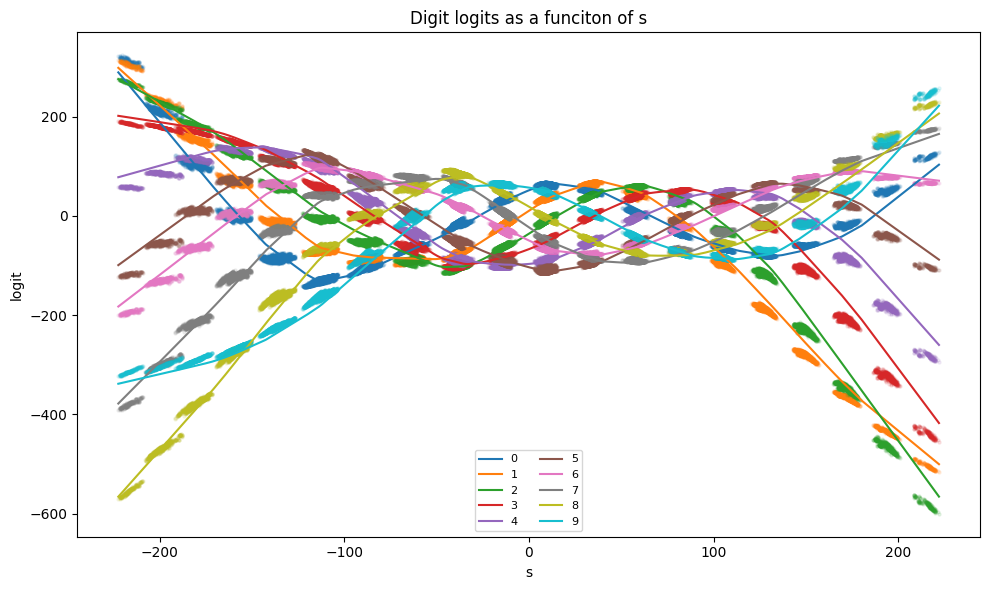

In [14]:
s = (pre_relu @ v).detach().cpu().numpy()
# s = ((pre_relu - mu) @ v).detach().cpu().numpy() # centered projection

# now we retrieve the targets
Ws = (W_mlp_out.T @ W_u.T).detach() 
logits = torch.stack([F.relu((r["x_in"] + r["attn_out"]) @ W_mlp_fc.T) @ Ws for r in rows]).detach().cpu().numpy()
digit_ids = np.array([tokenizer.char_to_enc[str(d)] for d in range(10)])
logits = logits[:, digit_ids]

# offset from the other summands
bias = torch.stack([((r["x_in"] + r["attn_out"]) @ W_u.T) for r in rows]).mean(dim=0).detach().numpy()
# bias = torch.stack([(r["x_in"] @ W_u.T) for r in rows]).mean(dim=0).detach().numpy()

def f(s, k):
    h = mu + s*v
    z = F.relu(h)
    return bias[k] + (z * Ws[:, k]).sum()

# plotting
xs = np.linspace(s.min(), s.max(), 500)
plt.figure(figsize=(10,6))
for j, tok_id in enumerate(digit_ids):
    plt.plot(xs, [f(x, tok_id) for x in xs], label=f"{j}")
    plt.scatter(s, logits[:, j], s=5, alpha=0.1)
plt.legend(ncol=2, fontsize=8)
plt.xlabel("s")
plt.ylabel("logit")
plt.title("Digit logits as a funciton of s")
plt.tight_layout()
plt.show()

The first thing to note is that the fit is not good near $s=\pm 225$, and the model does not quite capture the horizontal shelves of predictions. Since the logits themselves are not important, we plot the predicted digit as a function of $s$ also.

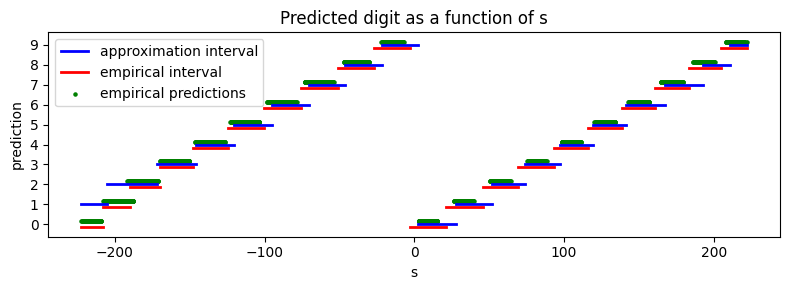

In [15]:
# because i am lazy, i find the s cluster with k-means.
from sklearn.cluster import KMeans

s_np = np.asarray(s)
logits_np = np.asarray(logits)
pred_digits = logits_np.argmax(axis=-1)
km = KMeans(n_clusters=20, random_state=0, n_init=100)
km.fit(s_np.reshape(-1, 1))
centers = km.cluster_centers_.flatten()
labels  = km.labels_             
order = np.argsort(centers)
centers_sorted = centers[order]
label_remap = {old: new for new, old in enumerate(order)}
labels_sorted = np.array([label_remap[l] for l in labels])
sperations = np.array([s.min()] + list((centers_sorted[:-1] + centers_sorted[1:])/2) + [s.max()])

#-- compute preds on a dense grid in s ---
xs = np.linspace(s.min(), s.max(), 1000)
ys = []
for j, tok_id in enumerate(digit_ids):
    y = [f(x, tok_id).item() for x in xs]
    ys.append(y)
ys = torch.tensor(ys)          # (10, 1000)
preds = ys.argmax(dim=0)       # (1000,)

# --- turn preds over xs into contiguous segments ---
xs_np = xs
preds_np = preds.cpu().numpy()
seg_starts = [xs_np[0]]
seg_digits = [int(preds_np[0])]
for i in range(1, len(xs_np)):
    if preds_np[i] != preds_np[i-1]:
        # close previous segment at xs[i]
        seg_starts.append(xs_np[i])
        seg_digits.append(int(preds_np[i]))
seg_starts.append(xs_np[-1])   # end of last segment

# --- empirical predictions from actual logits ---
logits_np = np.array(logits)
maxes = logits_np.argmax(axis=-1)   # (N,)

plt.figure(figsize=(8, 3))

# 1) approximation intervals from f(s,·): blue horizontal segments
approx_y_offset = - 0
for k in range(len(seg_starts) - 1):
    x0, x1 = seg_starts[k], seg_starts[k+1]
    d = seg_digits[k]
    y_line = d + approx_y_offset
    if k == 0:
        plt.plot([x0, x1], [y_line, y_line],
                 c="blue", lw=2, label="approximation interval")
    else:
        plt.plot([x0, x1], [y_line, y_line],
                 c="blue", lw=2)

# 2) empirical intervals from your `sperations`: red segments
emp_y_offset = -0.15
for i in range(len(sperations) - 1):
    d = (i % 10) # 9 - (i % 10)
    y_line = d + emp_y_offset
    if i == 0:
        plt.plot([sperations[i], sperations[i+1]],
                 [y_line, y_line],
                 c="red", lw=2, label="empirical interval")
    else:
        plt.plot([sperations[i], sperations[i+1]],
                 [y_line, y_line],
                 c="red", lw=2)

# 3) scatter of empirical argmax on actual samples: green points
plt.scatter(s, maxes + 0.15, c="green", alpha=1, s=5, label="empirical predictions")
plt.xlabel("s")
plt.ylabel("prediction")
plt.title("Predicted digit as a function of s")
plt.yticks(range(10))
plt.legend()
plt.tight_layout()
plt.show()

### What is even going on?

Perhaps the easiest way to show how the solution works is with an example. If we divide $s_i = -230 + 23.76 (a_i + b_i) + 2.47(a_{i-1} + b_{i-1}) - 2.12 r_{i-1}$ by $ 23.76$, we get the more interpretable
$$s_i^\prime := s_i / 23.76 = a_i + b_i + 0.104(a_{i-1} + b_{i-1}) - 0.09r_{i-1} - 9.68$$
and for this scaled version of $s_i$ the argmax of the logits yield the (partial) decision-rule $f(s) = 9$ for $s \in [-1,0]$ and $f(s)=0$ for $s \in (0,1]$ . Let us now consider the example $a_i + b_i = 9$ and $a_{i-1} + b_{i-1}=9$ 

$$s_i^\prime := 9 + 0.104 \cdot 9 - 0.09 r_{i-1} - 9.68 = 0.256 - 0.09 r_{i-1}$$

and for $r_{i-1}=0$ we get $s_i^\prime = 0.256$ while for $r_{i-1}=9$ we get $s_i^\prime = 0.256 - 0.81 = -0.554$. In this example we see how the solution is able to correctly carry even with cascades. We see how the models' solution ammends the $a_i + b_i + 0.1(a_{i-1}+b_{i-1}) \text{ mod } 10$ heuristic by multiplying $(a_{i-1}+b_{i-1})$ with $0.104$ instead of 1 to get a slight overshooting $0.104(a_{i-1}+b_{i-1})>1$. However, if no carry has occured, then the correction $- 0.09 r_{i-1}$ adjusts appropriately, and if a carry has occured then $r_{i-1}=0$ and then overshooting is correct. This slight adjustment is enough to give a correct decision-rule more generally. 

In [16]:
def get_si_scaled(ai, bi, aim1, bim1, rim1):
    return ai + bi + 0.104*(aim1 + bim1) - 0.09*rim1 - 9.68
print(get_si_scaled(ai=5, bi=4, aim1=4, bim1=5, rim1=9))
print(get_si_scaled(ai=5, bi=4, aim1=4, bim1=5, rim1=0))

-0.5540000000000003
0.2560000000000002


What we see is that $s\in[-225, 225]$ is partitioned into intervals where digit $d$ is the maximum. 

# Evaluating the final fit

In [17]:
def get_si(ai, bi, aim1, bim1, rim1):
   return -230.3056 + 23.7632*ai + 23.8031*bi + 2.4578*aim1 + 2.4756*bim1 - 2.1405*rim1

# An example with cascading
a = 38889
b = 11111
r = a+b

a_rev = str(a)[::-1]
b_rev = str(b)[::-1]
r_rev = str(r)[::-1]

# We are only predicting the 4 middle digits.
res = ""
for i in range(1, 5): 
   ai = int(a_rev[i])
   bi = int(b_rev[i])
   aim1 = int(a_rev[i-1])
   bim1 = int(b_rev[i-1])
   rim1 = int(r_rev[i-1])
   si = get_si(ai, bi, aim1, bim1, rim1)

   logits_lst = []
   for r in range(10):
      logit = f(si, k=r)
      logits_lst.append(logit.item())
   m = torch.tensor(logits_lst).argmax(dim=-1).item()
   res+=str(m)

print("predicted:", res)
print("true     :", r_rev[1:])

predicted: 0005
true     : 0005
